# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

In [2]:
def pareto_frontier(Xs, Ys, maxX = False, maxY = False):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

### Example 3: Max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

In [3]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

k1 = np.array([3.,2.])
p1 = np.array([4.,1.5])
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)

b = npr.uniform(1,3,2)
b_tch = torch.tensor(b, requires_grad = True)
# Formulate loss function
def loss(t,y,x,data,l = 5): 
    return t +y + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))+ l*torch.mean(torch.maximum(
        torch.maximum(k1_tch@x -data@k1_tch, torch.tensor(0.)) - y, 
        torch.tensor(0.,requires_grad = True))), t+y, torch.mean((((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()+ (torch.maximum(
        torch.maximum(k1_tch@x -data@k1_tch, torch.tensor(0.)) - y, 
        torch.tensor(0.,requires_grad = True))>=0.001).float())>=1).float())
#+ torch.maximum(k_tch@(x - b_tch),torch.tensor(0.))

def loss(t,x,data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum( data@k_tch + k1_tch@x -data@(k_tch + k1_tch), data@k_tch + k1_tch@x - x@(k_tch + k1_tch)) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean((torch.maximum(
        torch.maximum(data@k_tch + k1_tch@x -data@(k_tch + k1_tch), data@k_tch + k1_tch@x - x@(k_tch + k1_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float())
#+ torch.maximum(k_tch@(x - b_tch),torch.tensor(0.))

def loss(t,x,data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float())
#+ torch.maximum(k_tch@(x - b_tch),torch.tensor(0.))

def loss(t,x,alpha,data, mu = 1, l = 5, quantile = 0.95,target = 1.): 
    sums = torch.mean(torch.maximum(
        torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t - alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(1-quantile) + alpha
    return t + l*(sums - target) + (mu/2)*(sums - target)**2, t, torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()


def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)
data = np.load("data4.npy")
# np.save("data4.npy", data)

In [4]:
# data = gen_demand(n,N)
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
# y = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
# constraints += [cp.maximum(k1@(x_r-u),0) <= y]
# constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)
target = -0.2
s = 13
# # Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", init_eps = 1, seed = s)
# df_eps = result.df
# # Train A and b
# df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, init_eps=1)

# # Grid search epsilon
# dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_bval = -init@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 5, target_cvar = target, init_alpha = -0.1)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step= 100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin, init_mu = 1, init_lam = 5, target_cvar = target, init_alpha = -0.1)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 5,  target_cvar = target, init_alpha  =-0.1)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = -0.1)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0.1)
dfgrid2 = result5.df

In [5]:
A_fin, b_fin

(array([[ 1.07063027, -0.12409226],
        [ 0.42854979,  1.59071613]]),
 array([-1.56686479, -4.33028127]))

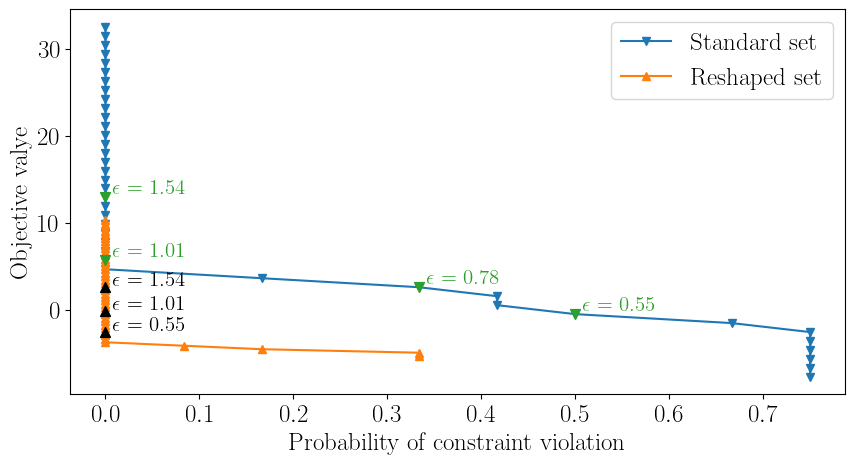

In [6]:
eps_list = np.linspace(0.01, 3, 40)
inds = [20,13,10,7]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
# ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# # ax1.set_yscale("log")
# ax1.set_xlabel("Size parameter $\epsilon$")
# ax1.set_ylabel("Value of constraint violation")
plt.figure(figsize=(10, 5))
plt.plot(dfgrid['Violations'][:], dfgrid['Test_val'][:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
for ind in range(4):
    plt.scatter(dfgrid['Violations'][inds[ind]],dfgrid['Test_val'][inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid['Violations'][inds[ind]],dfgrid['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(dfgrid2['Violations'],dfgrid2['Test_val'], color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
for ind in [0,1,3]:
    plt.scatter(dfgrid2['Violations'][inds[ind]],dfgrid2['Test_val'][inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid2['Violations'][inds[ind]],dfgrid2['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Probability of constraint violation")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves1.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


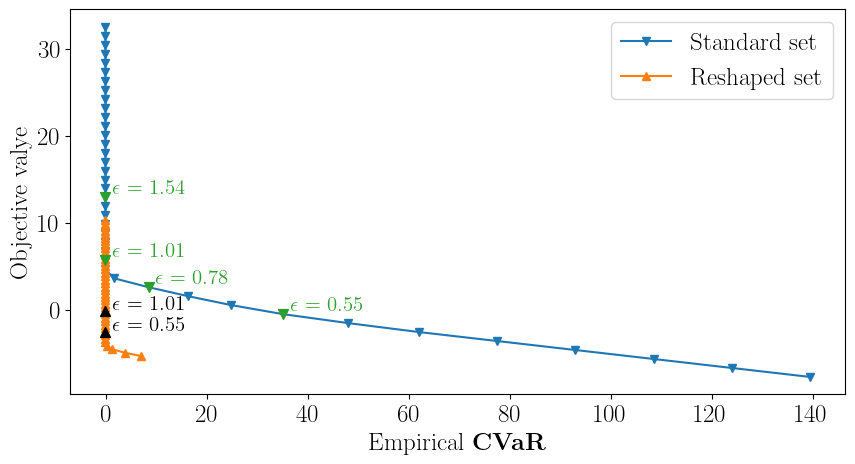

In [31]:
eps_list = np.linspace(0.01, 3, 40)
inds = [20,13,10,7]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
# ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# # ax1.set_yscale("log")
# ax1.set_xlabel("Size parameter $\epsilon$")
# ax1.set_ylabel("Value of constraint violation")
plt.figure(figsize=(10, 5))
plt.plot(dfgrid['Violation_val'][:], dfgrid['Test_val'][:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
for ind in range(4):
    plt.scatter(dfgrid['Violation_val'][inds[ind]],dfgrid['Test_val'][inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid['Violation_val'][inds[ind]],dfgrid['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(dfgrid2['Violation_val'],dfgrid2['Test_val'], color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
for ind in [1,3]:
    plt.scatter(dfgrid2['Violation_val'][inds[ind]],dfgrid2['Test_val'][inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (dfgrid2['Violation_val'][inds[ind]],dfgrid2['Test_val'][inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Empirical $\mathbf{CVaR}$")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_cvar.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


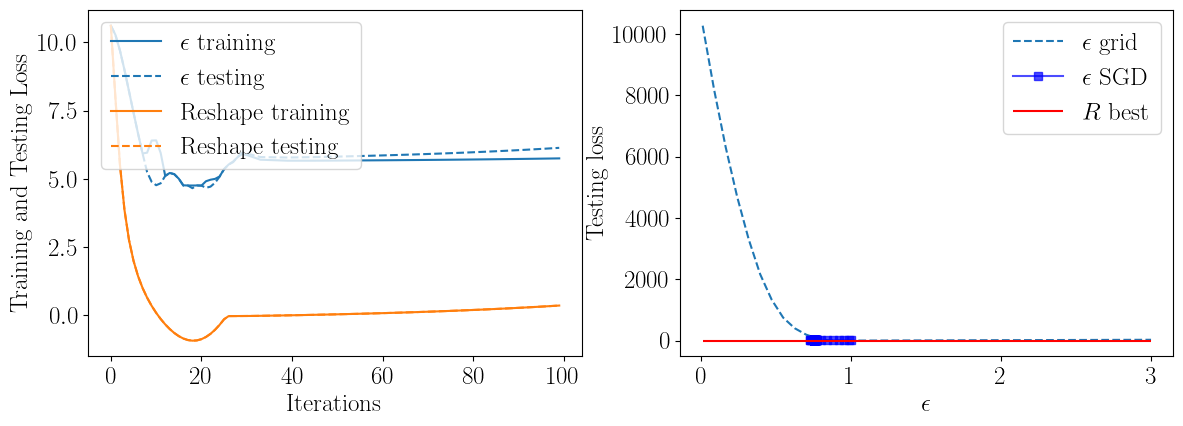

In [9]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)

# ax2.plot(df_r1["A_norm"],df_r1["Eval_val"], linestyle='-', marker=styles[j], color = "green", label="$R$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


In [10]:
x_opt_base = {}
x_opt_base1 = {}
x_opt_learned = {}
x_opt_learned1 = {}
t_learned = {}
t_base = {}
for ind in range(4):
    n = 2
    u = lro.UncertainParameter(n,
                            uncertainty_set=lro.Ellipsoidal(p=2,
                                                        A = (1/eps_list[inds[ind]])*result3.A, b = result3.b))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lro.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_opt_base[ind] = x_r.value

    t_base[ind] = t.value

    n = 2
    u = lro.UncertainParameter(n,
                            uncertainty_set=lro.Ellipsoidal(p=2,
                                                        A = (1/eps_list[inds[ind]])*A_fin, b = b_fin))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lro.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_opt_learned[ind] = x_r.value

    t_learned[ind] = t.value
    x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
x_opt_learned,x_opt_base,t_learned, t_base


({0: array([6.14179444e-11, 5.53206650e+00]),
  1: array([3.21249482e-10, 3.60838895e+00]),
  2: array([1.70741754e-10, 2.78395571e+00]),
  3: array([1.90796160e-09, 1.95952247e+00])},
 {0: array([1.40162056e-09, 8.07597689e+00]),
  1: array([8.32933972e-10, 5.26769983e+00]),
  2: array([3.71697362e-10, 4.06415252e+00]),
  3: array([3.74900857e-10, 2.86060521e+00])},
 {0: array(-0.23649591),
  1: array(-0.15425867),
  2: array(-0.11901414),
  3: array(-0.08376961)},
 {0: array(8.67607338),
  1: array(5.65912346),
  2: array(4.36614492),
  3: array(3.07316638)})

In [11]:
A_fin, b_fin
result3.A, result3.b

(array([[0.34802978, 0.22183809],
        [0.22183809, 2.28620322]]),
 array([-1.89004551, -5.64576754]))

<Figure size 500x500 with 0 Axes>

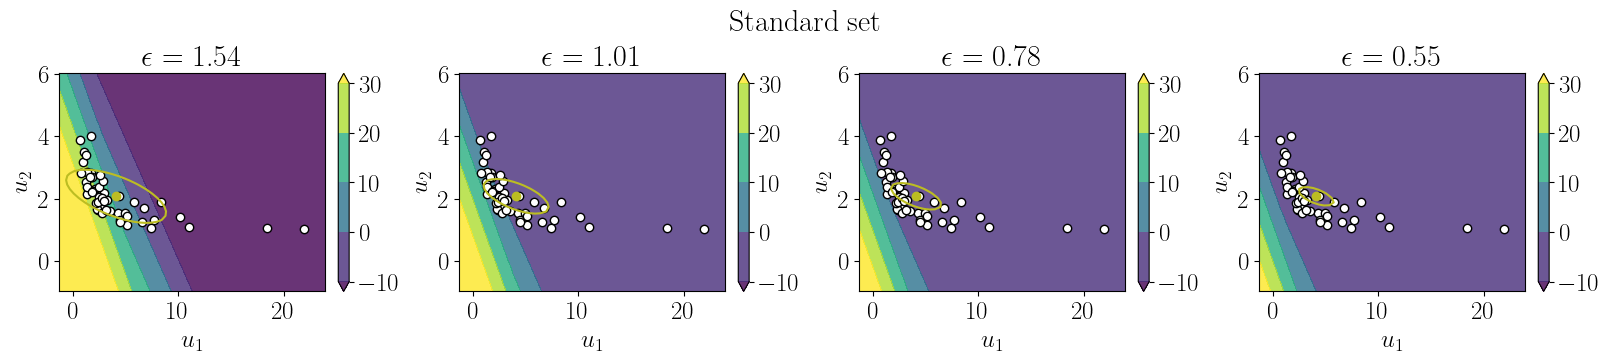

In [27]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
K =1
plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
      

g_level_learned = {}
g_level_base = {}

for ind in range(4):
# init_set = np.zeros((num_p,num_p))
    g_level_learned[ind] = np.zeros((num_p,num_p))
    g_level_base[ind] = np.zeros((num_p,num_p))

    # # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    # for i in range(num_p):
    #     for j in range(num_p):
    #         u_vec = [x[i,j], y[i,j]]
    #         fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
    #         init_set[i,j] = np.linalg.norm(init@ u_vec + init_bval)
    #         g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
    #         g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)

    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds[ind]])*result3.b)
            # init_set[i,j] = np.linalg.norm(init@ u_vec - init@np.mean(data, axis = 0))
            g_level_learned[ind][i,j] = np.maximum(k @ x_opt_learned[ind] - p @ x_opt_learned[ind], k @ x_opt_learned[ind] - p @ u_vec) + np.maximum(k1 @ (x_opt_learned[ind]-u_vec),0) 
            g_level_base[ind][i,j] = np.maximum(k @ x_opt_base[ind] - p @ x_opt_base[ind], k @ x_opt_base[ind] - p @ u_vec) + np.maximum(k1 @ (x_opt_base[ind]-u_vec),0)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)

ax1.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[0]],2)))
# Set x axis label for the contour plot
ax1.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,init_set[0][k_ind], [1], colors = ["tab:olive"])
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[0][k_ind], [1], colors = ["tab:orange"])
a1 = ax1.contourf(x,y,g_level_base[0],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1], color = "white" ,edgecolors= "black")
ax1.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
aa = fig.colorbar(a1, ax = ax1)

ax2.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[1]],2)))
# Set x axis label for the contour plot
ax2.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,init_set[1][k_ind], [1], colors = ["tab:olive"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_base[1],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1], color = "white", edgecolors= "black")
ax2.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a2,ax = ax2, boundaries=np.linspace(-10,20,10))


ax3.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[2]],2)))
# Set x axis label for the contour plot
ax3.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax3.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax3.contour(x,y,init_set[2][k_ind], [1], colors = ["tab:olive"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a3 = ax3.contourf(x,y,g_level_base[2],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax3.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax3.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a3,ax = ax3, boundaries=np.linspace(-10,20,10))

ax4.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[3]],2)))
# Set x axis label for the contour plot
ax4.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax4.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax4.contour(x,y,init_set[3][k_ind], [1], colors = ["tab:olive"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a4 = ax4.contourf(x,y,g_level_base[3],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax4.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax4.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a4,ax = ax4, boundaries=np.linspace(-10,20,10))
fig.suptitle("Standard set")

plt.savefig("Reshaped1_1.pdf", bbox_inches='tight')


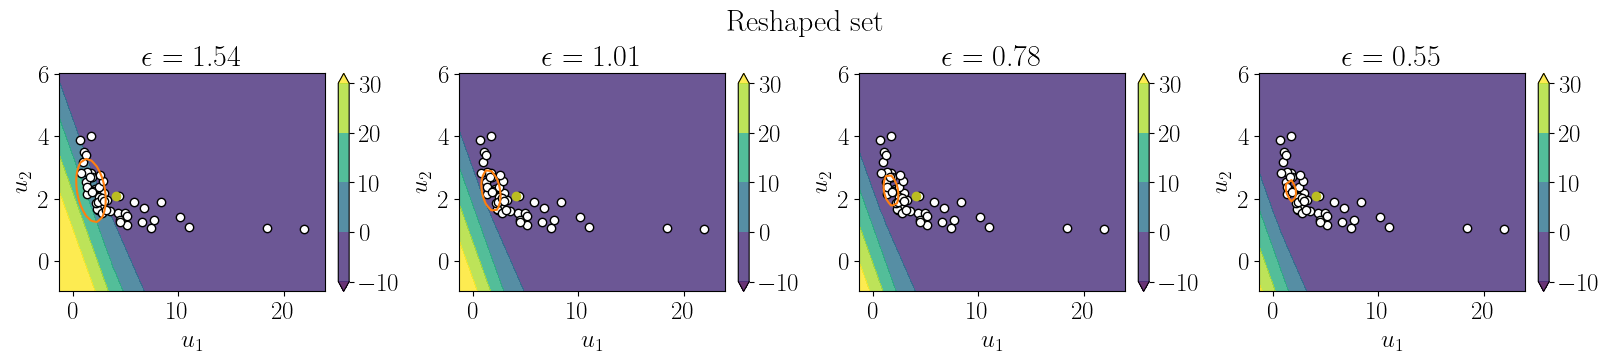

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)

ax1.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[0]],2)))
# Set x axis label for the contour plot
ax1.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,fin_set[0][k_ind], [1], colors = ["tab:orange"])

a1 = ax1.contourf(x,y,g_level_learned[0],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax1.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
aa = fig.colorbar(a1, ax = ax1)

ax2.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[1]],2)))
# Set x axis label for the contour plot
ax2.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,fin_set[1][k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_learned[1],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax2.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a2,ax = ax2, boundaries=np.linspace(-10,20,10))


ax3.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[2]],2)))
# Set x axis label for the contour plot
ax3.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax3.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax3.contour(x,y,fin_set[2][k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a3 = ax3.contourf(x,y,g_level_learned[2],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax3.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax3.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a3,ax = ax3, boundaries=np.linspace(-10,20,10))

ax4.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[3]],2)))
# Set x axis label for the contour plot
ax4.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax4.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax4.contour(x,y,fin_set[3][k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a4 = ax4.contourf(x,y,g_level_learned[3],np.arange(-10, 40, 10),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax4.scatter(data[:,0],data[:,1], color = "white",edgecolors= "black")
ax4.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1],color = ["tab:olive"])
fig.colorbar(a4,ax = ax4, boundaries=np.linspace(-10,20,10))
fig.suptitle("Reshaped set")


plt.savefig("Reshaped2_1.pdf", bbox_inches='tight')


### Example 4: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [461]:
def loss(L,y,Y,s,data,l=10):
    sums = 0
    Nsample = data.shape[0]
    for i in range(Nsample):
        sums += torch.sum(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True)))
        sums += torch.sum(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True)))
        sums += torch.maximum(-torch.tensor(r)@y - torch.tensor(r)@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))
    return L + torch.tensor(l)*sums/Nsample, L, sums/Nsample
n = 10
m = 4
data = np.random.normal(0,3,(400,m))


In [462]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
# u = lro.UncertainParameter(m,
#                                 uncertainty_set = lro.Ellipsoidal(p=2, 
#                                                                   rho=1., data =data, loss =loss))
K = 1
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.MRO(p=2, K = K,
                                                                  rho=1., data =data, loss =loss, uniqueA = True))
Astart = u.uncertainty_set._init_A
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate problem constants
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)
r = np.random.uniform(20,40,n)


# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", init_eps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_bval = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = init, init_b = init_bval, seed = s)
 
dfgrid = result4.df

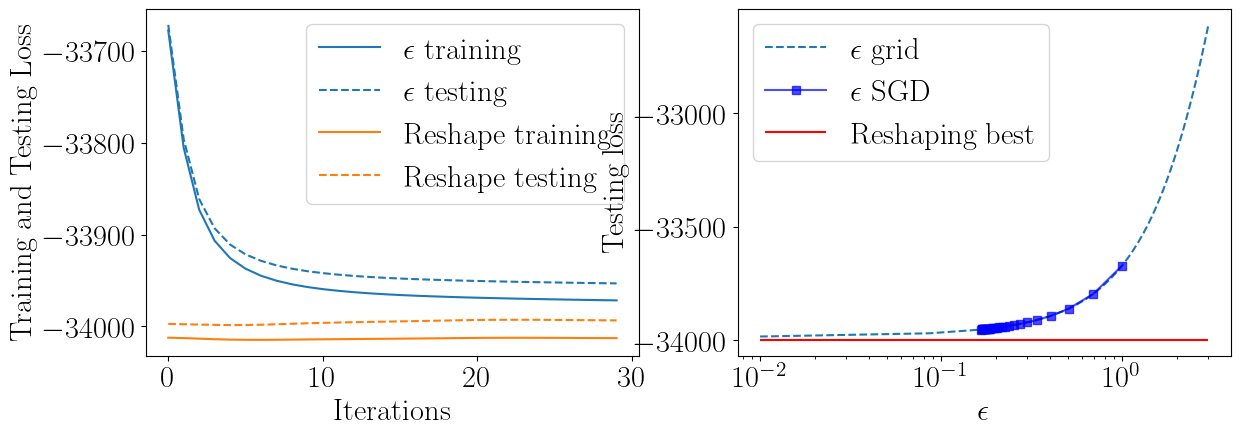

In [463]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df_r1['step'], df_r1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df_r1['step'], df_r1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "Reshaping best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.set_xscale("log")
ax2.legend()
plt.show()


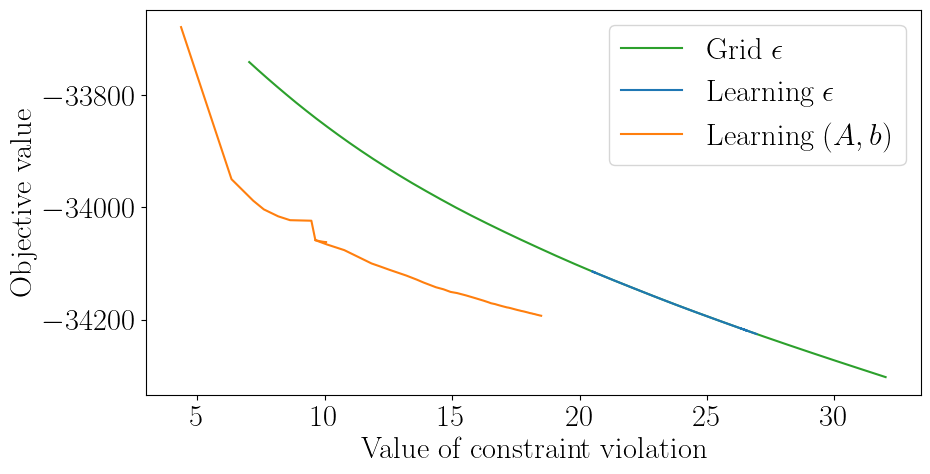

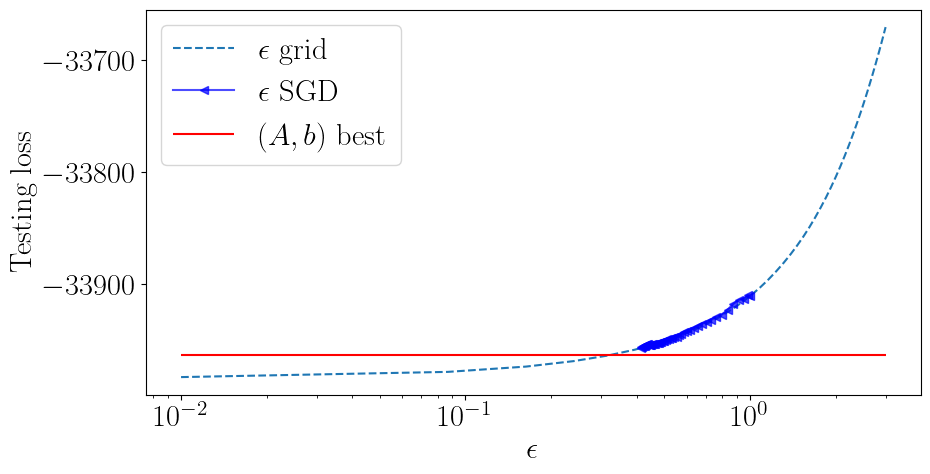

In [466]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
plt.plot(new[0], new[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.plot(new1[0], new1[1], color="tab:orange")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


In [465]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
# u = lro.UncertainParameter(m,
#                                 uncertainty_set = lro.Ellipsoidal(p=2, 
#                                                                   rho=1., data =data, loss =loss))
K = 5
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.MRO(p=2, K = K,
                                                                  rho=1., data =data, loss =loss, uniqueA = True))
Astart = u.uncertainty_set._init_A
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate problem constants
# C = 2000
# c = np.random.uniform(300,500,n)
# Q = np.random.uniform(-2,2,(n,m))
# d = np.random.uniform(100,200,n)
# t = np.random.uniform(1,3,n)
# h = np.random.uniform(1,3,n)
# r = np.random.uniform(20,40,n)


# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", init_eps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_bval = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, init_A = None, init_b = init_bval )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = None, init_b = init_bval, seed = s)
 
dfgrid = result4.df

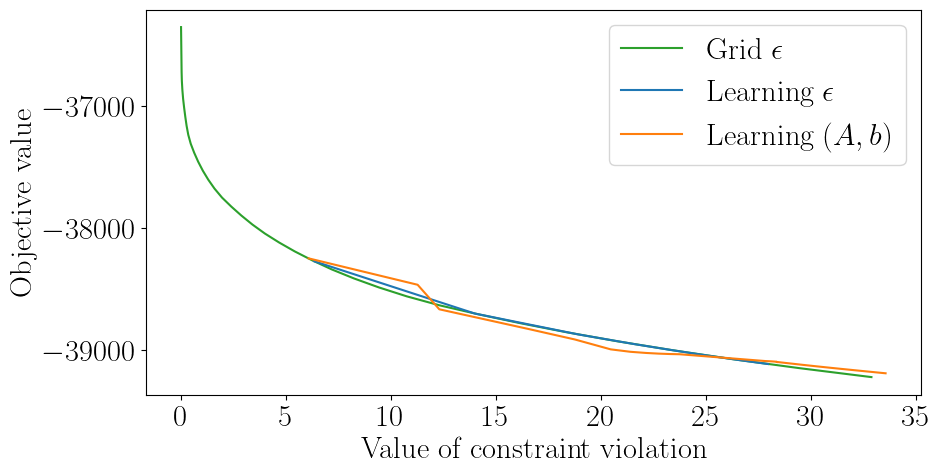

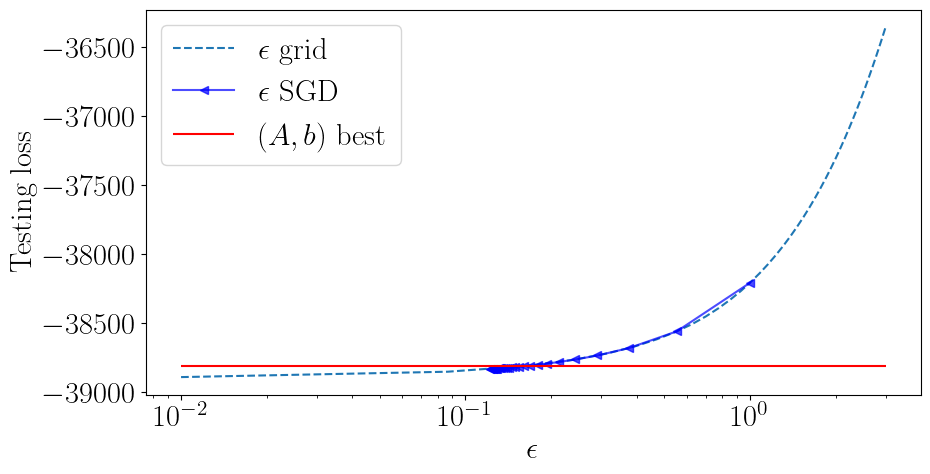

In [459]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
plt.plot(new[0], new[1], color="tab:orange")
plt.plot(new1[0], new1[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


In [ ]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))

# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", init_eps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_bval = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = init, init_b = init_bval, seed = s)
 
dfgrid = result4.df

In [ ]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
# new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
# plt.plot(new[0], new[1], color="tab:orange")
plt.plot(new1[0], new1[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


### Example 4: Affine Adjustable Robust Optimization: Hydro power plant


In [ ]:
def loss(tau, x0, x1, x2, x3, x4, x5, data,l=5):
    sums = 0
    x = {}
    x[0] = x1
    x[1] = x2 
    x[2] = x3 
    x[3] = x4
    x[4] = x5
    Nsample = data.shape[0]
    for ind in range(Nsample):
        for t in range(T):
            sums += torch.maximum(-x0[t] - x[t]@torch.tensor(P[t])@data[ind], torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.tensor(l0) - torch.tensor(lhigh) + torch.tensor(np.ones(t+1)@P[t])@data[i] - torch.sum(torch.stack([x0[i] + x[i]@torch.tensor(P[i])@data[ind] for i in range(t+1)])), torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.tensor(llow) - torch.tensor(l0) - torch.tensor(np.ones(t+1)@P[t])@data[ind] + torch.sum(torch.stack([x0[i] + x[i]@torch.tensor(P[i])@data[ind] for i in range(t+1)])), torch.tensor(0.,requires_grad = True))
    return tau + torch.tensor(l)*sums/Nsample, tau, sums/Nsample


In [ ]:

import math
T = 5
data = np.random.normal(1,0.1,(100,T))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
u = lro.UncertainParameter(T,
                                uncertainty_set = lro.Ellipsoidal(p=2, 
                                                                  rho=1, data =data, loss =loss))
# K = 1
# u = lro.UncertainParameter(T,
#                                 uncertainty_set = lro.MRO(p=2, K = K, 
#                                                                   rho=1, data =data, loss =loss, uniqueA = True))
# formulate cvxpy variable
tau = cp.Variable()
x0 = cp.Variable(T)
x = {}
for t in range(T):
    x[t] = cp.Variable(t+1)

# formulate problem constants
P = {}
for t in range(T):
    P[t] = np.eye(T)[0:t+1,:]
l0 = 1
lhigh = 5
llow = 1
c = np.zeros(T)
for i in range(T):
    c[i] = 10 + 5*math.sin(math.pi*(1-(i+1))/3)


# formulate objective
objective = cp.Minimize(tau)

# formulate constraints
constraints = [-cp.sum([c[t]*x0[t] + c[t]*x[t]@P[t]@u for t in range(T)]) <= tau]
constraints += [cp.maximum(*[l0 - lhigh + np.ones(t+1)@P[t]@u - cp.sum([x0[i] + x[i]@P[i]@u for i in range(t+1)]) for t in range(T)], *[llow - l0 - np.ones(t+1)@P[t]@u  + cp.sum([x0[i] + x[i]@P[i]@u for i in range(t+1)]) for t in range(T)]) <= 0]
for t in range(T):
    constraints += [-x0[t] - x[t]@P[t]@u <= 0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_bval = -init@np.mean(data, axis=0)
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", init_eps = 0.001, seed = s)
# df_eps  = result.df
# Train A and b
result1 = prob.train(lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", init_A = init, init_b = init_bval, seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_eps = 0.001)
df_r2 = result3.df
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.0001, 0.01, 40), init_A = init, init_b = init_bval, seed = s)
dfgrid = result4.df
result5 = prob.grid(epslst = np.linspace(0.0001, 0.01, 40), init_A = A_fin, init_b = b_fin, seed = s)
dfgrid2 = result5.df


In [ ]:

# Plot results
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df_r1['step'], df_r1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df_r1['step'], df_r1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "Reshaping best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.set_xscale("log")
ax2.legend()
plt.show()


In [ ]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
plt.figure(figsize=(10,5))
plt.scatter(df_r2['Violations'], df_r2['Opt_val'], color="tab:blue", label=r"Learning $\epsilon$")
plt.plot(df1['Violations'], df1['Opt_val'], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Hydro.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Hydro_train.pdf",bbox_inches='tight')
